### Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import tensorflow as tf
from torchvision import transforms
import time

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings("ignore")

#### 1. Get the data and print the head

In [4]:
# CODE HERE
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/train.csv")

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 2. What is the shape of the data?

In [5]:
train.shape

(1460, 81)

#### 3. Is the SalePrice feature normally distributed? (show the description)

In [6]:
train.describe()["SalePrice"]


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

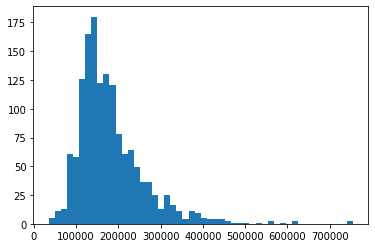

In [7]:
plt.hist(train.SalePrice,50)
plt.show()

#### 4. What are the features data types?

In [8]:
train_datatypes = list(train.dtypes)
train_datatypes

[dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('int64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype(

___
## Preproccessing 

#### 5. Make a new variable that contains a list of all the features containing missing values. 
#### 5.a. Print the feature's name and how many.
for example:<br>
LotFrontage has 259 missing values out of 1460

In [9]:
nullValues = dict(train.isnull().sum())

for k in list(nullValues.keys()):
  if nullValues[k] != 0:
    print(f"{k} has {nullValues[k]} missing values out of {train.shape[0]}")
  if nullValues[k] == 0:
    del nullValues[k]

LotFrontage has 259 missing values out of 1460
Alley has 1369 missing values out of 1460
MasVnrType has 8 missing values out of 1460
MasVnrArea has 8 missing values out of 1460
BsmtQual has 37 missing values out of 1460
BsmtCond has 37 missing values out of 1460
BsmtExposure has 38 missing values out of 1460
BsmtFinType1 has 37 missing values out of 1460
BsmtFinType2 has 38 missing values out of 1460
Electrical has 1 missing values out of 1460
FireplaceQu has 690 missing values out of 1460
GarageType has 81 missing values out of 1460
GarageYrBlt has 81 missing values out of 1460
GarageFinish has 81 missing values out of 1460
GarageQual has 81 missing values out of 1460
GarageCond has 81 missing values out of 1460
PoolQC has 1453 missing values out of 1460
Fence has 1179 missing values out of 1460
MiscFeature has 1406 missing values out of 1460


#### 6. Show the missing values in a bar plot
hint - make a dictionary in question 5 

<BarContainer object of 19 artists>

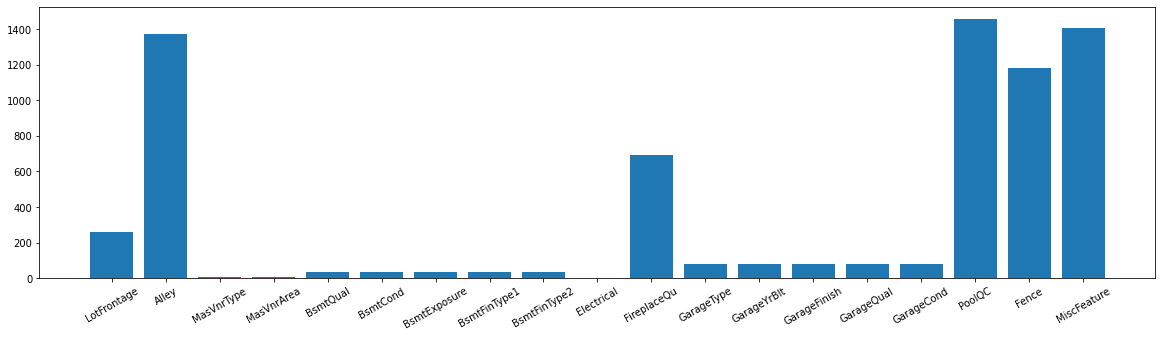

In [10]:
keys = nullValues.keys()
values = nullValues.values()

plt.figure(figsize=(20, 5))
plt.xticks(rotation=30)
plt.bar(keys, values)

7. Drop features with large number of missing values (Alley, PoolQC, Fence, MiscFeature)

In [11]:
removeFeatures = ["Alley", "PoolQC", "Fence", "MiscFeature"]
print(train.shape)
for f in removeFeatures:
  try:
    train.drop([f], axis=1, inplace=True)
    print(f"Removed {f}")
  except:
    pass
    
print(train.shape)

(1460, 81)
Removed Alley
Removed PoolQC
Removed Fence
Removed MiscFeature
(1460, 77)


#### 8. Update and remove these features from the list from question 5

In [12]:
print(len(nullValues))
for f in removeFeatures:
  del nullValues[f]
print(len(nullValues))

19
15


#### 9. Handle missing values - arrange the features to numerical, categorical and features containing year lists
make sure that year related features are not in the numerical list as well.

In [13]:
numeric_data = train.select_dtypes(include=[np.number])
categorical_data = train.select_dtypes(exclude=[np.number])

yearical = []
categorical = list(categorical_data.columns)
for key in list(numeric_data.columns):
    if "Year" in key or "Yr" in key:
      yearical.append(key)
      numeric_data.drop([key], axis=1, inplace=True)

numerical = list(numeric_data.columns)

#### 9.1. Print the year features list

In [14]:
yearical

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### 9.2. Print the numeric features list

In [15]:
numerical

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SalePrice']

#### 9.3. Print the categorical features list

In [16]:
categorical

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

#### 10. Check unique values for each categorical feature

In [17]:
for f in categorical:
  values = train[f].unique()
  print("Unique values for {} ({})".format(f, len(values)))
  print(values)
  print("----")

Unique values for MSZoning (5)
['RL' 'RM' 'C (all)' 'FV' 'RH']
----
Unique values for Street (2)
['Pave' 'Grvl']
----
Unique values for LotShape (4)
['Reg' 'IR1' 'IR2' 'IR3']
----
Unique values for LandContour (4)
['Lvl' 'Bnk' 'Low' 'HLS']
----
Unique values for Utilities (2)
['AllPub' 'NoSeWa']
----
Unique values for LotConfig (5)
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
----
Unique values for LandSlope (3)
['Gtl' 'Mod' 'Sev']
----
Unique values for Neighborhood (25)
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
----
Unique values for Condition1 (9)
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
----
Unique values for Condition2 (8)
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
----
Unique values for BldgType (5)
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twn

#### 11. Replace numeric missing values with mean and categorical missing values with mode

In [18]:
for f in numerical:
  mean = train[f].mean()
  train[f] = train[f].fillna(mean)

for f in categorical:
  mode = train[f].mode()[0]

  train[f] = train[f].fillna(mode)
  
for f in yearical:
  mean = train[f].mean()
  train[f] = train[f].fillna(mean)

#### 12. Recheck for null values

In [19]:
newNullValues = dict(train.isnull().sum())

print(len(newNullValues))
for k in list(newNullValues.keys()):
  if newNullValues[k] == 0:
    print(f"{k} has {newNullValues[k]} missing values out of {train.shape[0]}")
    del newNullValues[k]

print(len(newNullValues))

77
Id has 0 missing values out of 1460
MSSubClass has 0 missing values out of 1460
MSZoning has 0 missing values out of 1460
LotFrontage has 0 missing values out of 1460
LotArea has 0 missing values out of 1460
Street has 0 missing values out of 1460
LotShape has 0 missing values out of 1460
LandContour has 0 missing values out of 1460
Utilities has 0 missing values out of 1460
LotConfig has 0 missing values out of 1460
LandSlope has 0 missing values out of 1460
Neighborhood has 0 missing values out of 1460
Condition1 has 0 missing values out of 1460
Condition2 has 0 missing values out of 1460
BldgType has 0 missing values out of 1460
HouseStyle has 0 missing values out of 1460
OverallQual has 0 missing values out of 1460
OverallCond has 0 missing values out of 1460
YearBuilt has 0 missing values out of 1460
YearRemodAdd has 0 missing values out of 1460
RoofStyle has 0 missing values out of 1460
RoofMatl has 0 missing values out of 1460
Exterior1st has 0 missing values out of 1460
Exte

In [20]:
newNullValues

{}

___
## EDA

#### 13. Print the head again

In [21]:
# CODE HERE
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


#### 14. How many features are categorical? How many features are numerical? How many features containing year?

In [22]:
categorical_len = len(categorical)
numerical_len = len(numerical)
yearical_len = len(yearical)

print("Categorical features: {}, Numerical features: {}, Yearical features: {}".format(categorical_len, numerical_len, yearical_len))

Categorical features: 39, Numerical features: 34, Yearical features: 4


#### 15. Print a bar plot for every categorical feature with the sale price

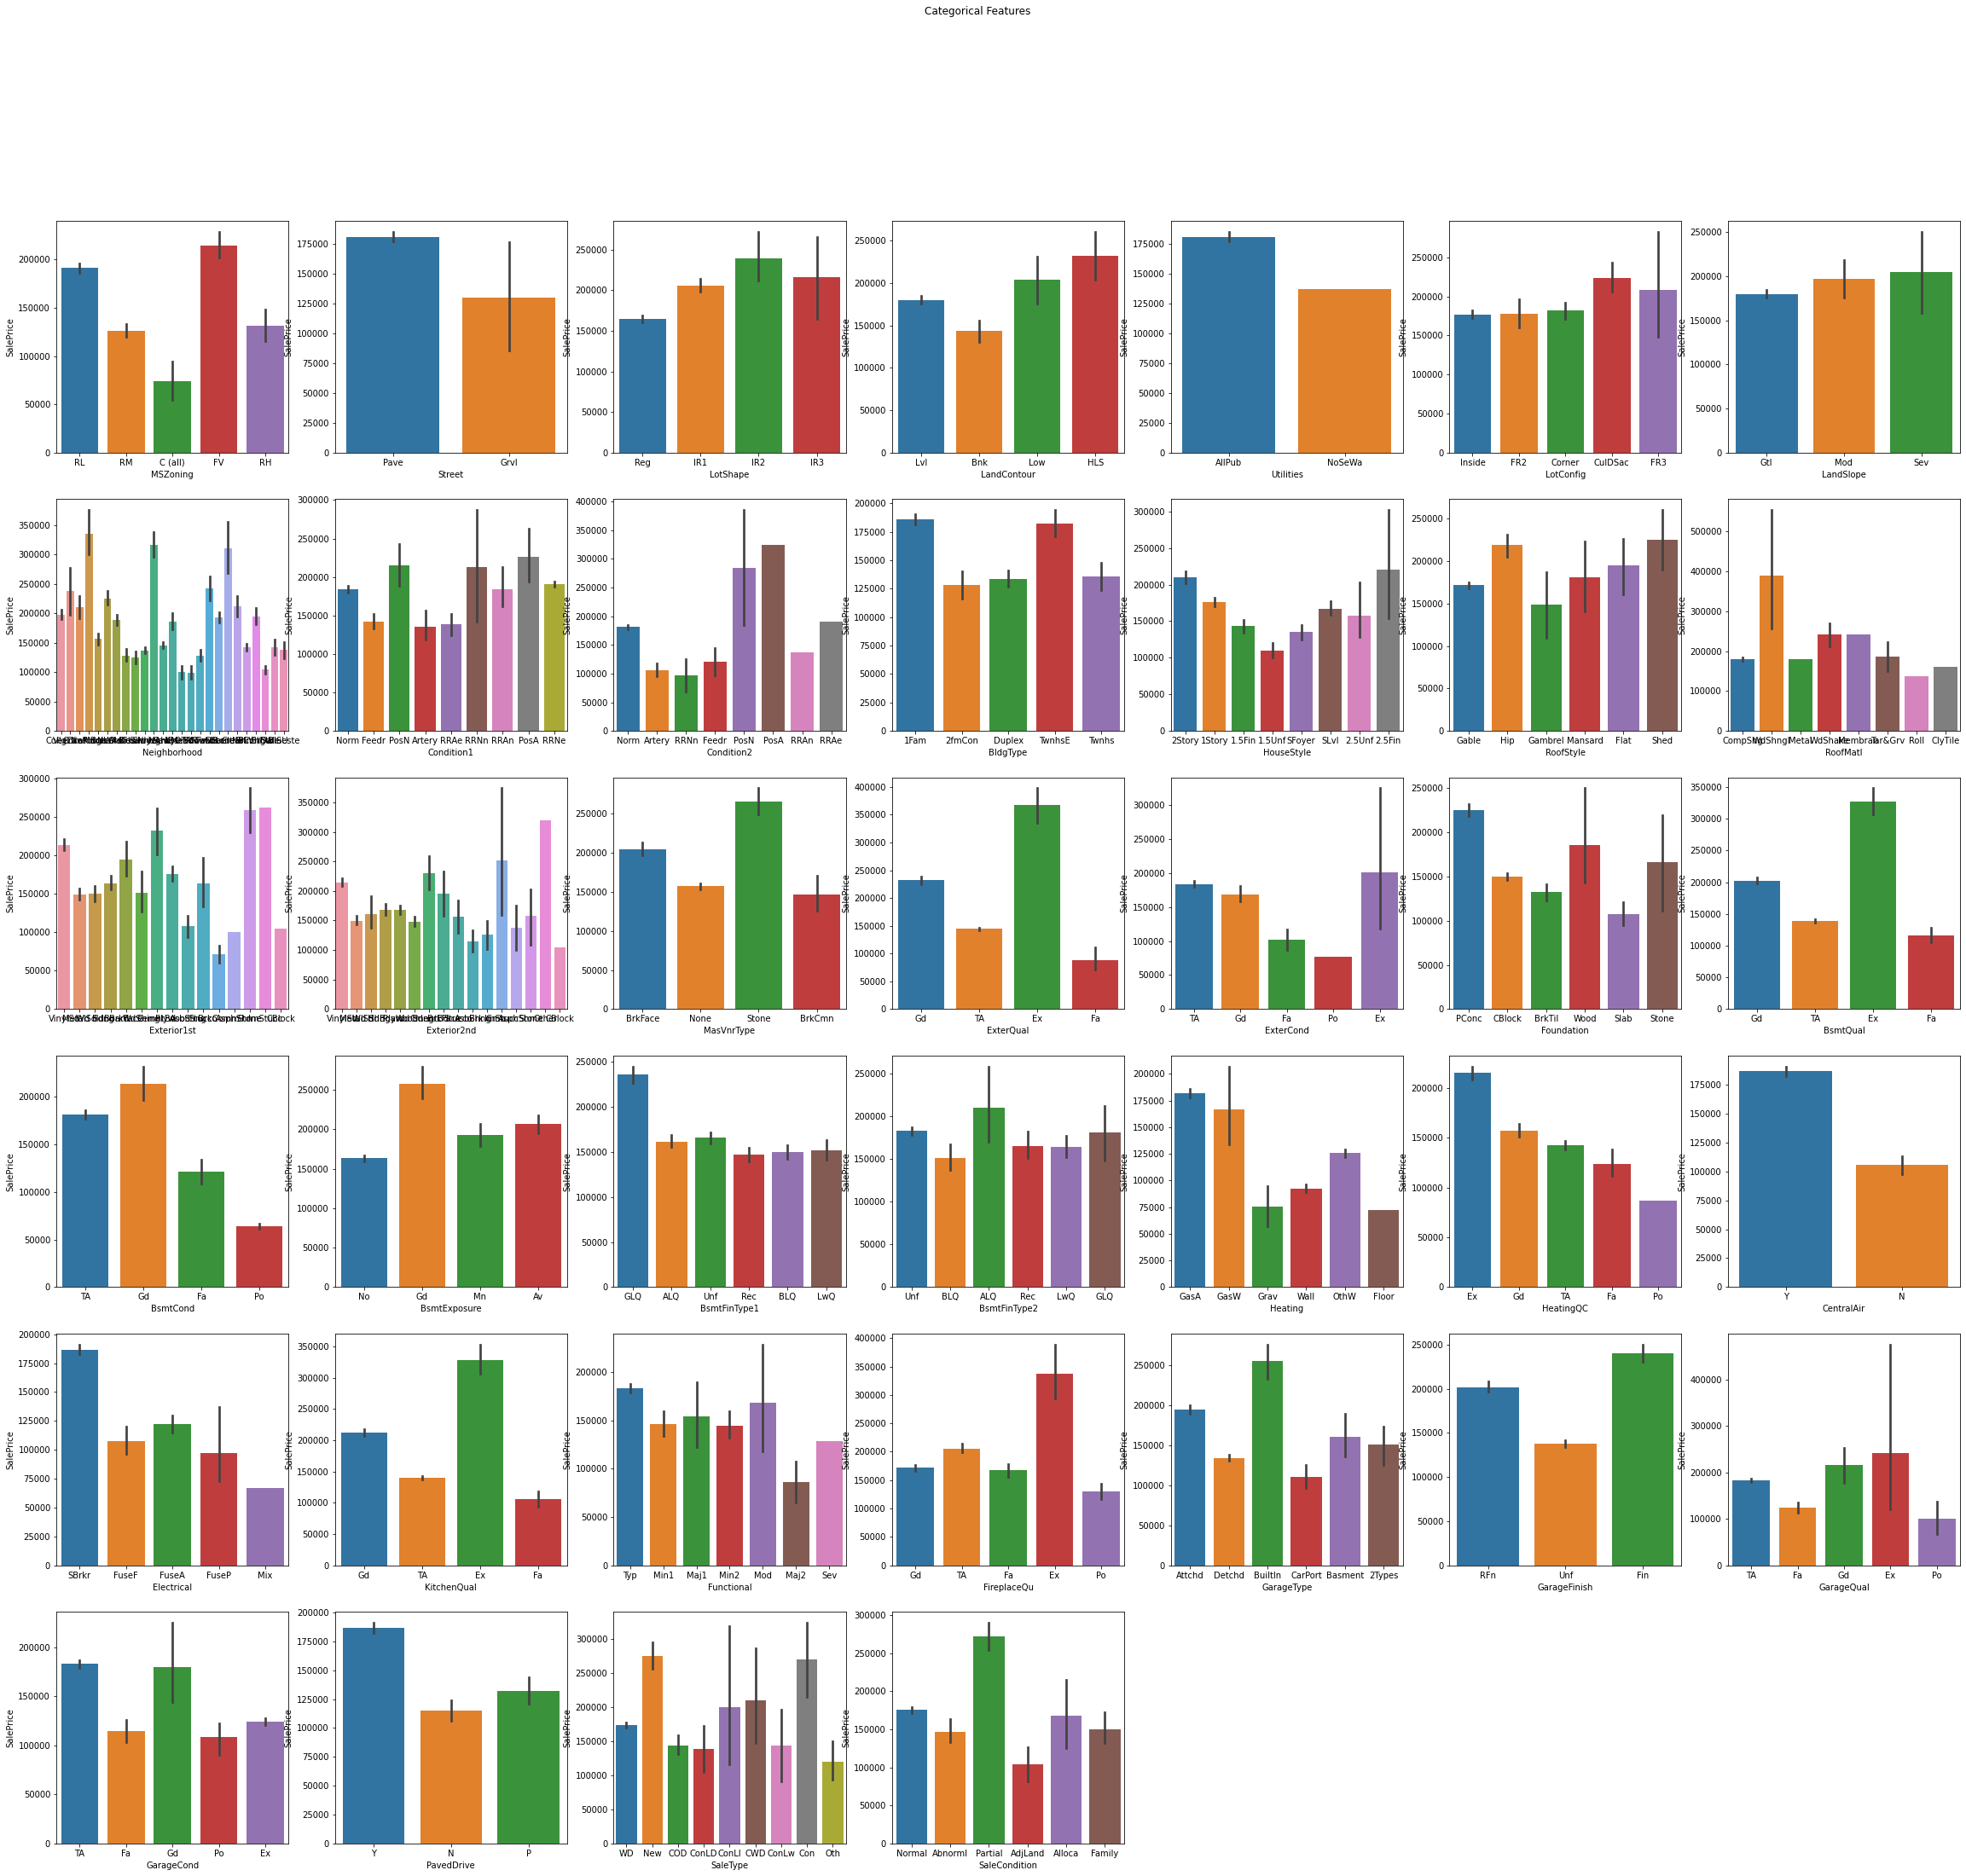

In [23]:
fig = plt.figure(figsize=(40, 35))
fig.suptitle('Categorical Features')

for i in range(len(categorical)):
  ax = plt.subplot(6, 7, i+1)
  sns.barplot(y="SalePrice", x=categorical[i], data=train, orient='v')

plt.show()

#### 16. Check for realtionship between numeric features and the sales price with scatterplot

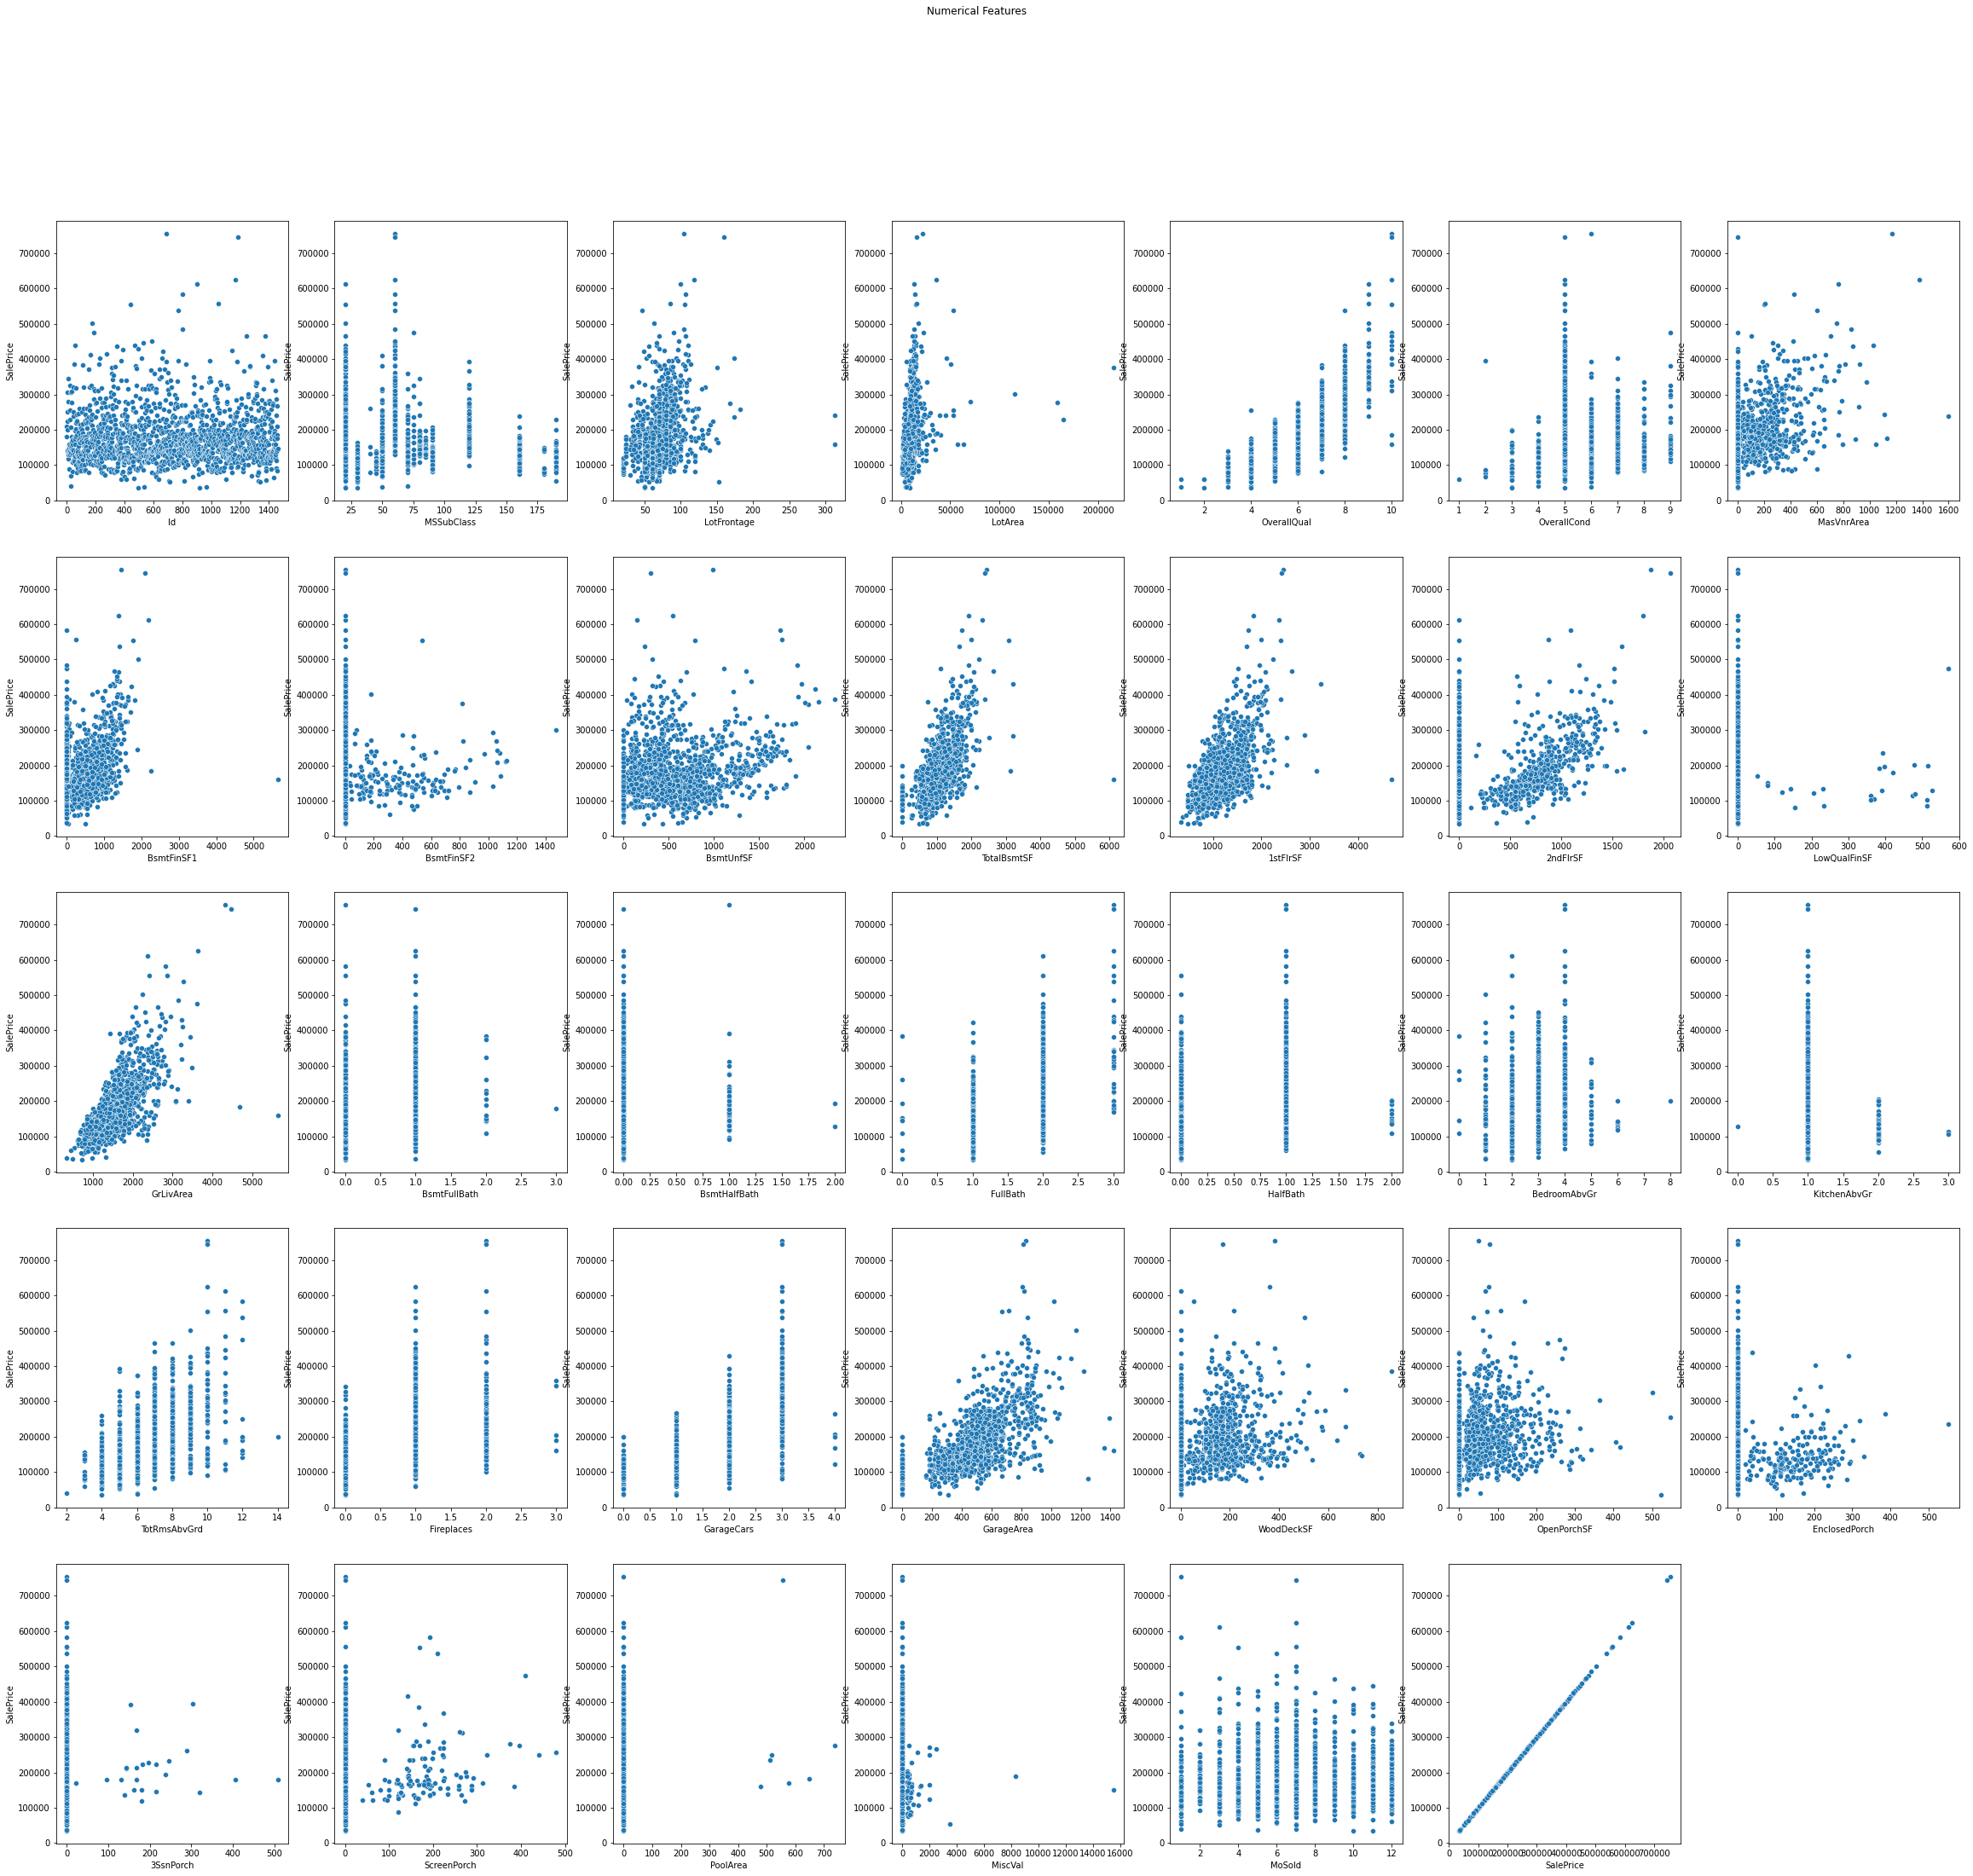

In [24]:
fig = plt.figure(figsize=(40, 35))
fig.suptitle('Numerical Features')

for i in range(len(numerical)):
  ax = plt.subplot(5, 7, i+1)
  sns.scatterplot(y="SalePrice", x=numerical[i], data=train)

plt.show()

#### 17. Check for realtionship between year features and the sales price with line plot

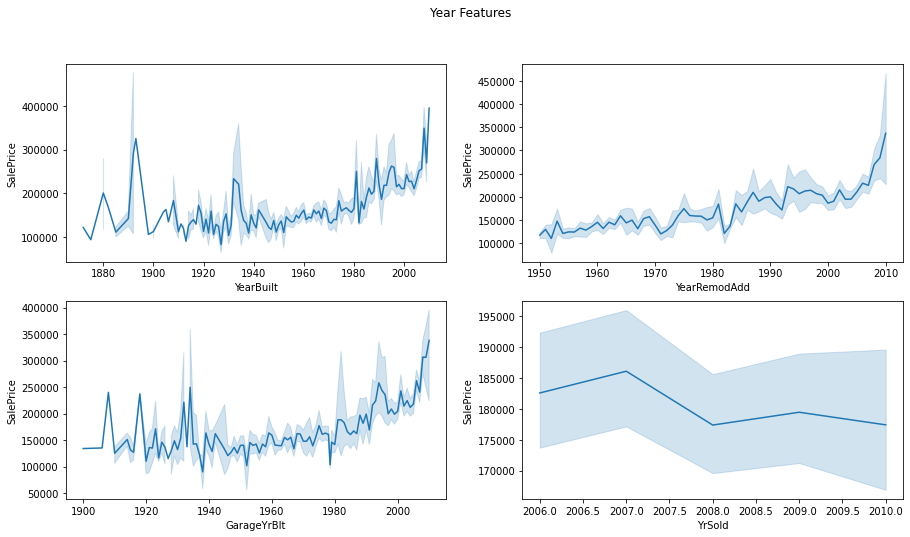

In [25]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Year Features')

for i in range(len(yearical)):
  ax = plt.subplot(2, 2, i+1)
  sns.lineplot(y="SalePrice", x=yearical[i], data=train)

plt.show()

#### 18. Check for outliers with boxplot 

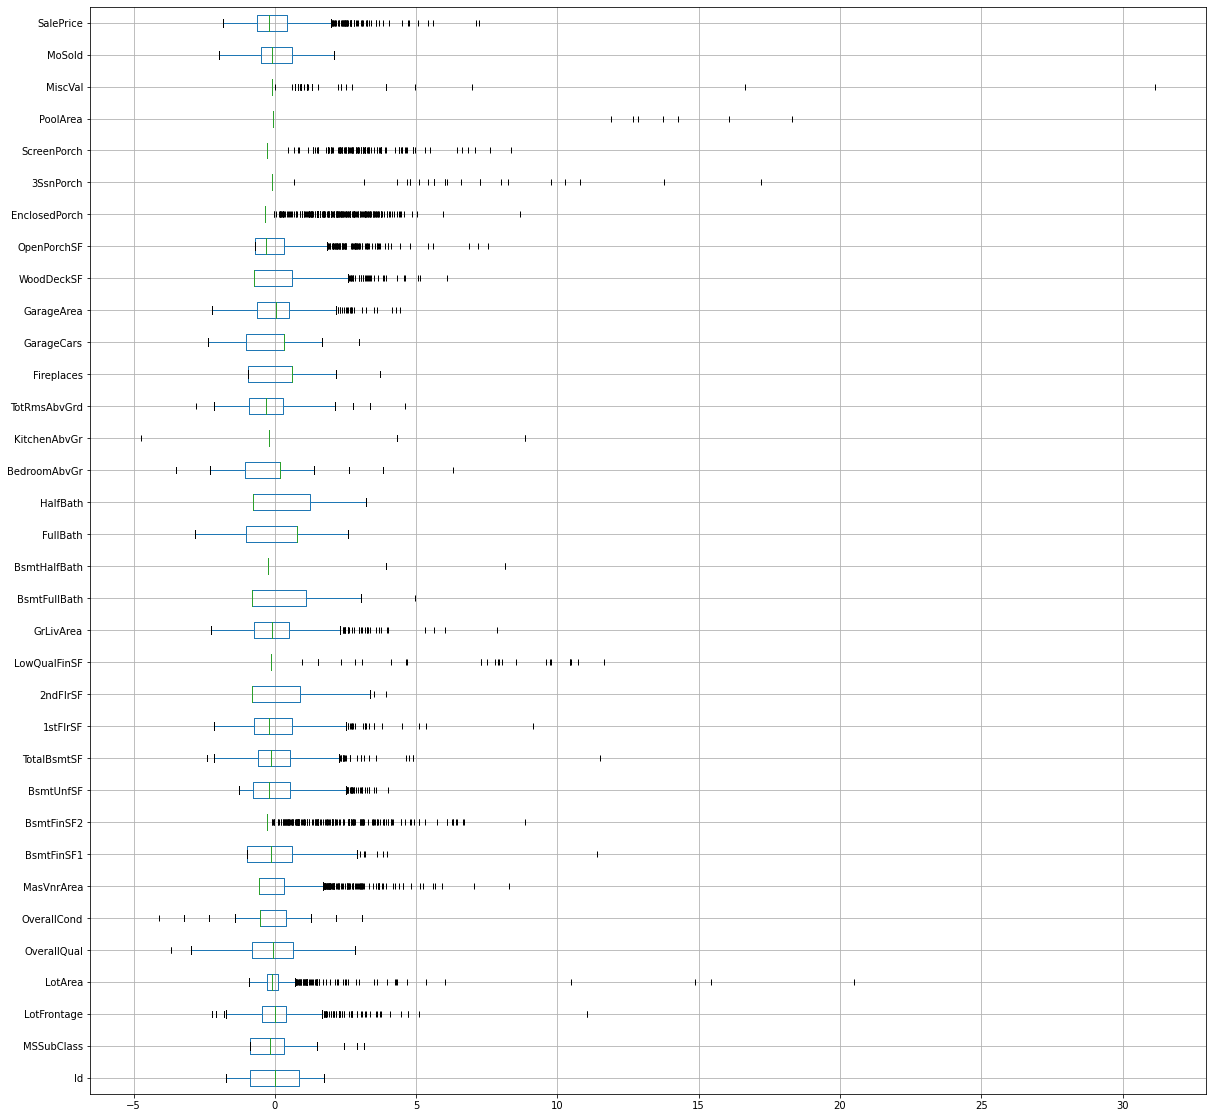

In [26]:
normalized_df=(train-train.mean())/train.std() 
normalized_df[numerical].boxplot(figsize=(20,20), vert=False, sym='|')


#### 19. Drop the Id column

In [27]:
try:
  train.drop(["Id"], axis=1, inplace=True)
except:
  pass

#### 20. One hot encode the data - dummies

In [28]:
train = pd.get_dummies(train, prefix=categorical, columns=categorical, drop_first=True)
train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,...,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0,0,1,...,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0,0,1,...,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,0,0,1,...,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0,0,1,...,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


___
## Split the data 

#### 21. Split the data to X and y

In [29]:
X = train.drop('SalePrice', axis=1).values
y = train['SalePrice'].values

#### 22. Split the data to training set and validation set (30% test size)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### 23. Scale the training data with MinMaxScaler

In [31]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

___
## Model

#### 24. Build a regression PyTorch Artificial Neural Network
Layer 1 fully connected - 236 inputs, 512 outputs<br>
Layer 2 fully connected - 512 inputs, 256 outputs<br>
Layer 3 fully connected - 256 inputs, 128 outputs<br>
Layer 4 fully connected - 128 inputs, 64 outputs<br>
Output layer - 64 inputs, 1 output<br>

40% Dropout after the 2nd layer<br>
Rectified Linear Unit activation function for all layers

In [32]:
X.shape

(1460, 236)

In [33]:
class ANN_Reg(nn.Module):
    def __init__(self,size_list):
        super(ANN_Reg,self).__init__()
        layers=[]
        self.size_list = size_list
        for i in range(len(size_list)-2):
            if i == 2:
              layers.append(nn.Dropout(p=0.4))

            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(size_list[-2],size_list[-1]))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

#### 25. Create the network

In [34]:
model = ANN_Reg([236,512,256,128,64,1])

print(model)

ANN_Reg(
  (net): Sequential(
    (0): Linear(in_features=236, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)


#### 26. Convert the data numpy arrays to tensors

In [35]:
#X_train, X_test, y_train, y_test
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

#### 27. Make torch DataSets and DataLoaders
use batch_size = 64, shuffle = True to train loader and shuffle = False to validation loader

In [36]:
num_workers = 2

train_dataset = utils.TensorDataset(X_train,y_train)
train_loader = utils.DataLoader(train_dataset, shuffle=True,batch_size=64, num_workers=num_workers)

test_dataset = utils.TensorDataset(X_test,y_test)
test_loader = utils.DataLoader(test_dataset, shuffle=False,batch_size=64, num_workers=num_workers)

#### 28. Define loss function and optimizer
MSELoss loss function and Adam optomizer with 0.001 learning rate

In [37]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 29. Check for GPU

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


___
## Train and Validate

#### 30. set empty lists for epoch numbers, train loss list and validation loss list
set epochs = 10

In [39]:
epochs = 10

In [40]:
def train_epoch(model,train_loader,criterion,optimizer):
    model.train()
    model.to(device)
    
    running_loss = 0.0
    start_time = time.time()
    # run training
    for batch_idx, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        outputs= model.forward(data) #forward
        loss = criterion(outputs,target) # divergence
        running_loss+=loss.item()
        loss.backward()
        optimizer.step()        
    end_time = time.time()
    
    running_loss /= len(train_loader)
    # print('Loss : ',running_loss, ' Time: ',end_time-start_time,'s')
    return running_loss
    
    

In [41]:
def test_model(model,test_loader,criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        acc_val = 0.0
        total_precitions = 0.0 
        running_val_loss = 0.0
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model.forward(data)
            total_precitions+=target.size(0)
            acc_val += abs(scaler.inverse_transform(target.detach().numpy()) - scaler.inverse_transform(outputs.detach().numpy())).sum()
            loss = criterion(outputs,target) 
            running_val_loss+=loss.item()      

        running_val_loss /= len(test_loader)
        acc_val/=total_precitions
        return running_val_loss,acc_val
    

#### 31. Set the training mode to on  and train the model

In [46]:
# training mode -> ON
# reset every run

epoch_list=[]
Train_loss=[]
Test_loss=[]
Test_acc=[]
for epoch in range(epochs):
    print('*'*20)
    train_loss = train_epoch(model,train_loader,criterion,optimizer)
    test_loss,test_acc = test_model(model,test_loader,criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print(f'Epoch: {epoch+1} \t Acc: {test_acc} \tTraining Loss: {train_loss:.4f}\tValidation Loss: {test_loss:.4f}')
    
    # next epoch
    epoch_list.append(epoch+1)

********************
Epoch: 1 	 Acc: 19121.50428082192 	Training Loss: 0.0004	Validation Loss: 0.0029
********************
Epoch: 2 	 Acc: 18491.762557077625 	Training Loss: 0.0004	Validation Loss: 0.0027
********************
Epoch: 3 	 Acc: 18769.44663242009 	Training Loss: 0.0004	Validation Loss: 0.0027
********************
Epoch: 4 	 Acc: 18363.69006849315 	Training Loss: 0.0003	Validation Loss: 0.0026
********************
Epoch: 5 	 Acc: 18473.780964611873 	Training Loss: 0.0004	Validation Loss: 0.0027
********************
Epoch: 6 	 Acc: 18497.12357305936 	Training Loss: 0.0003	Validation Loss: 0.0026
********************
Epoch: 7 	 Acc: 19480.811643835616 	Training Loss: 0.0003	Validation Loss: 0.0027
********************
Epoch: 8 	 Acc: 18917.780679223742 	Training Loss: 0.0003	Validation Loss: 0.0026
********************
Epoch: 9 	 Acc: 19340.619006849316 	Training Loss: 0.0003	Validation Loss: 0.0028
********************
Epoch: 10 	 Acc: 19246.122003424658 	Training Loss: 0.00

#### 32. Plot the Train and Validation loss for each epoch

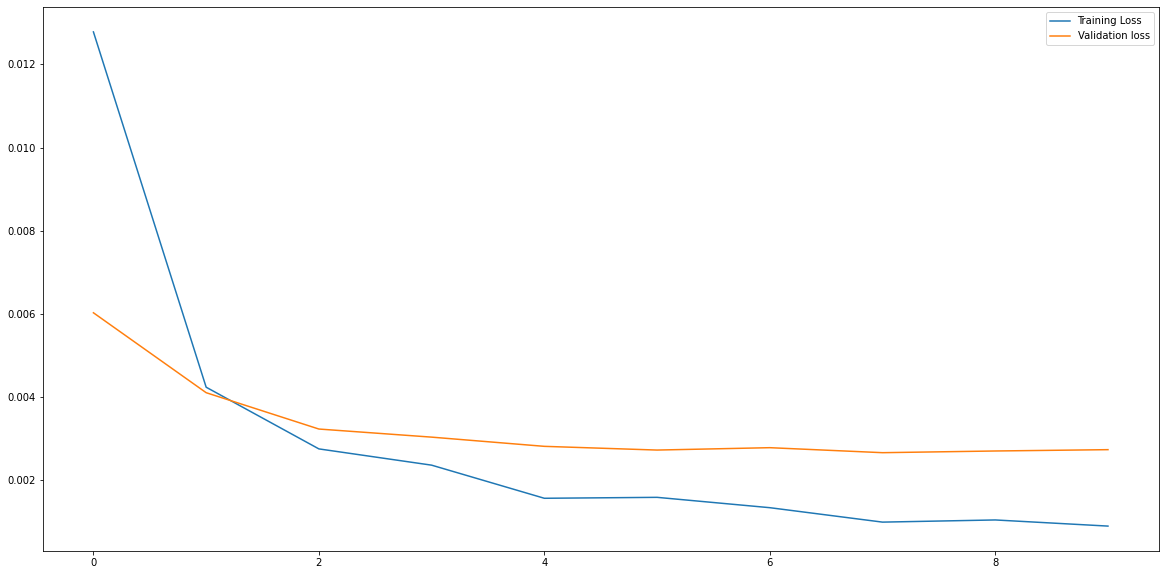

In [43]:
# plt.title('Training loss')
plt.figure(figsize=(20,10))
plt.plot(Train_loss, label="Training Loss")
plt.plot(Test_loss, label="Validation loss")
plt.legend()
plt.show()

#### What can you say about the plot?

In [44]:
# ANSWER HERE